In [1]:
#Importing fastai will also import numpy, pytorch, etc. 
from fastai.vision import *
from numbers import Integral
import seaborn as sns
from sklearn.datasets import make_moons, make_blobs, make_circles, make_classification
import pdb
import contextlib
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
#Modified from 
K=2
class MultiTransformLabelList(LabelList):
    def __getitem__(self,idxs:Union[int,np.ndarray])->'LabelList':
        "return a single (x, y) if `idxs` is an integer or a new `LabelList` object if `idxs` is a range."
        idxs = try_int(idxs)
        if isinstance(idxs, Integral):
            if self.item is None: x,y = self.x[idxs],self.y[idxs]
            else:                 x,y = self.item   ,0
            if self.tfms or self.tfmargs:
                #I've changed this line to return a list of augmented images
                x = [x.apply_tfms(self.tfms, **self.tfmargs) for _ in range(K)]
            if hasattr(self, 'tfms_y') and self.tfm_y and self.item is None:
                y = y.apply_tfms(self.tfms_y, **{**self.tfmargs_y, 'do_resolve':False})
            if y is None: y=0
            return x,y
        else: return self.new(self.x[idxs], self.y[idxs])
        
#I'll also need to change the default collate function to accomodate multiple augments
def MixmatchCollate(batch):
    batch = to_data(batch)
    if isinstance(batch[0][0],list):t
        batch = [[torch.stack(s[0]),s[1]] for s in batch]
    return torch.utils.data.dataloader.default_collate(batch)


In [3]:
#Grab file path to cifar dataset. Will download data if not present
path = untar_data(URLs.CIFAR)

#Custom ImageList with filter function
class MixMatchImageList(ImageList):
    def filter_train(self,num_items,seed=2343):
        train_idxs = np.array([i for i,o in enumerate(self.items) if Path(o).parts[-3] != "test"])
        valid_idxs = np.array([i for i,o in enumerate(self.items) if Path(o).parts[-3] == "test"])
        np.random.seed(seed)
        keep_idxs = np.random.choice(train_idxs,num_items,replace=False)
        self.items = np.array([o for i,o in enumerate(self.items) if i in np.concatenate([keep_idxs,valid_idxs])])
        return self
    
#Create two databunch objects for the labeled and unlabled images. A fastai databunch is a container for train, validation, and
#test dataloaders which automatically processes transforms and puts the data on the gpu.
data_labeled = (MixMatchImageList.from_folder(path)
                .filter_train(250) #Use 500 labeled images for traning
                .split_by_folder(valid="test") #test on all 10000 images in test set
                .label_from_folder()
                .transform(get_transforms(),size=32)
                #On windows, must set num_workers=0. Otherwise, remove the argument for a potential performance improvement
                .databunch(bs=64,num_workers=0)
                .normalize(cifar_stats))
data_labeled2 = (MixMatchImageList.from_folder(path)
                .filter_train(500) #Use 500 labeled images for traning
                .split_by_folder(valid="test") #test on all 10000 images in test set
                .label_from_folder()
                .transform(get_transforms(),size=32)
                #On windows, must set num_workers=0. Otherwise, remove the argument for a potential performance improvement
                .databunch(bs=64,num_workers=0)
                .normalize(cifar_stats))
data_labeled3 = (MixMatchImageList.from_folder(path)
                .filter_train(1000) #Use 500 labeled images for traning
                .split_by_folder(valid="test") #test on all 10000 images in test set
                .label_from_folder()
                .transform(get_transforms(),size=32)
                #On windows, must set num_workers=0. Otherwise, remove the argument for a potential performance improvement
                .databunch(bs=64,num_workers=0)
                .normalize(cifar_stats))

data_labeled4 = (MixMatchImageList.from_folder(path)
                .filter_train(2000) #Use 500 labeled images for traning
                .split_by_folder(valid="test") #test on all 10000 images in test set
                .label_from_folder()
                .transform(get_transforms(),size=32)
                #On windows, must set num_workers=0. Otherwise, remove the argument for a potential performance improvement
                .databunch(bs=64,num_workers=0)
                .normalize(cifar_stats))
data_labeled5 = (MixMatchImageList.from_folder(path)
                .filter_train(4000) #Use 500 labeled images for traning
                .split_by_folder(valid="test") #test on all 10000 images in test set
                .label_from_folder()
                .transform(get_transforms(),size=32)
                #On windows, must set num_workers=0. Otherwise, remove the argument for a potential performance improvement
                .databunch(bs=64,num_workers=0)
                .normalize(cifar_stats))


train_set = set(data_labeled.train_ds.x.items)
src = (ImageList.from_folder(path)
        .filter_by_func(lambda x: x not in train_set)
        .split_by_folder(valid="test"))
src.train._label_list = MultiTransformLabelList
data_unlabeled = (src.label_from_folder()
         .transform(get_transforms(),size=32)
         .databunch(bs=128,collate_fn=MixmatchCollate,num_workers=0)
         .normalize(cifar_stats))

#Databunch with all 50k images labeled, for baseline
data_full = (ImageList.from_folder(path)
        .split_by_folder(valid="test")
        .label_from_folder()
        .transform(get_transforms(),size=32)
        .databunch(bs=128,num_workers=0)
        .normalize(cifar_stats))

In [4]:
def mixup(a_x,a_y,b_x,b_y,alpha=0.75):
    l = np.random.beta(alpha,alpha)
    l = max(l,1-l)
    x = l * a_x + (1-l) * b_x
    y = l* a_y + (1-l) * b_y
    return x,y

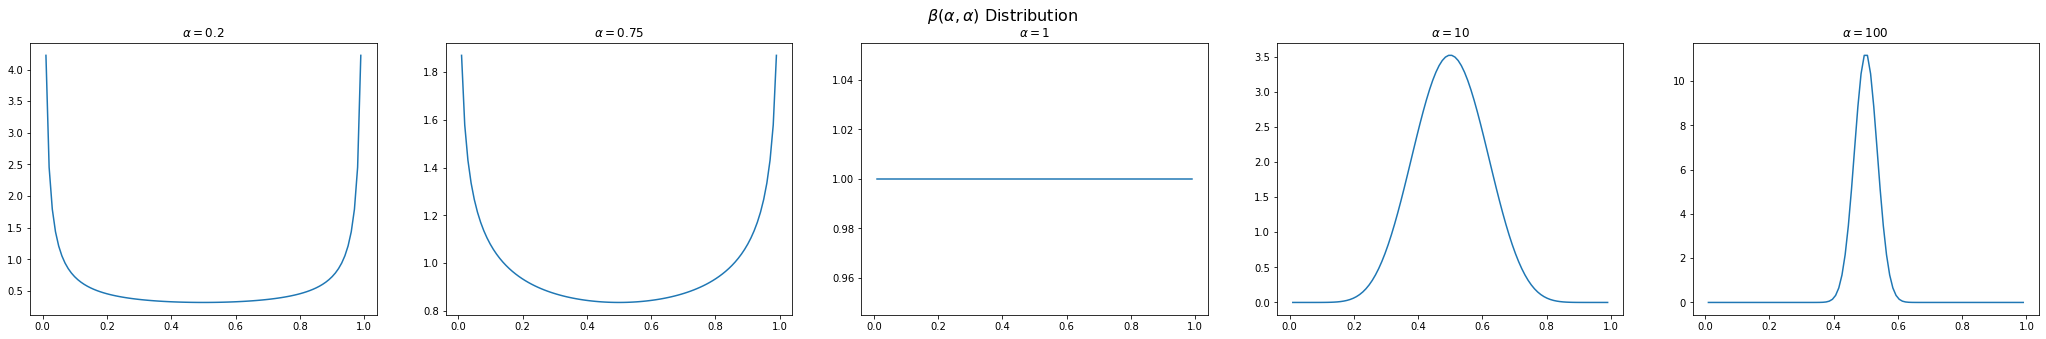

In [5]:

from scipy.stats import beta
x = np.linspace(0.01,0.99, 100)
fig, axes = plt.subplots(1,5,figsize=(36,5))
fig.suptitle(r"$\beta(\alpha,\alpha)$ Distribution",fontsize=16)
alphas = [0.2,0.75,1,10,100]
for a, ax in zip(alphas,axes.flatten()):
    ax.set_title(r"$\alpha={}$".format(a))
    ax.plot(x, beta.pdf(x, a, a))


In [6]:

def sharpen(p,T=0.5):
    u = p ** (1/T)
    return u / u.sum(dim=1,keepdim=True)

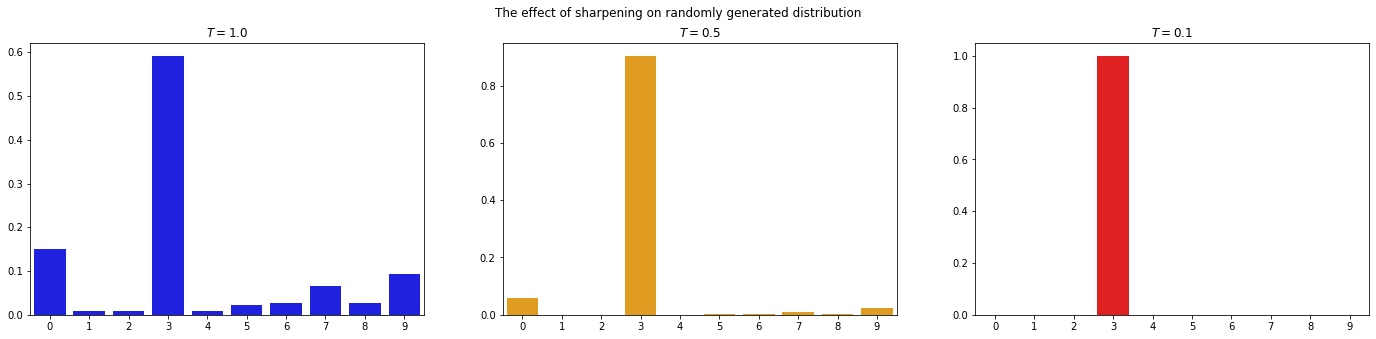

In [7]:
a = torch.softmax(torch.randn(10),0)
fig, axes = plt.subplots(1,3,figsize=(24,5))
fig.suptitle("The effect of sharpening on randomly generated distribution")
sns.barplot(x=np.arange(10),y=a,color="blue",ax=axes[0])
axes[0].set_title("$T = 1.0$")
sns.barplot(x=np.arange(10),y=sharpen(a[None,:],0.5)[0],color="orange",ax=axes[1])
axes[1].set_title("$T = 0.5$")
sns.barplot(x=np.arange(10),y=sharpen(a[None,:],0.1)[0],color="red",ax=axes[2])
axes[2].set_title("$T = 0.1$");

In [8]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [9]:

class EntropyMinTrainer(LearnerCallback):
    def __init__(self, learn, T=0.5):
        super().__init__(learn)
        self.T = T
        
    def on_train_begin(self, **kwargs):
        self.l_dl = iter(data_labeled.train_dl)
        self.it = 0
        
    def on_batch_begin(self, train, last_input, **kwargs):
        if not train: return 
        with torch.no_grad():
            ul_labels = sharpen(torch.softmax(self.learn.model(last_input),dim=1),T=self.T)
            #ul_labels = torch.softmax(self.learn.model(*last_input),dim=1)
        
        self.it += 1
        ramp = self.it / 800.0 if self.it < 800 else 1.0
        return {"last_target": (ul_labels,ramp)}
    
    def on_backward_begin(self, last_loss, last_output, **kwargs):
        try:
            l_x,l_y = next(self.l_dl)
        except:
            self.l_dl = iter(data_labeled.train_dl)
            l_x,l_y = next(self.l_dl)
            
        real_preds = self.learn.model(l_x)
        real_loss = F.cross_entropy(real_preds,l_y)
        return {"last_loss": last_loss + real_loss}
    
def entropy_min_loss(preds,target,ramp=None):
    if ramp is None:
        return F.cross_entropy(preds,target)
    preds = torch.softmax(preds,dim=1)
    return 10.0 * ramp * F.mse_loss(preds,target)
    #p = torch.softmax(preds,dim=1)
    #return -(p * torch.log(p)).sum(dim=1).mean()
    #d = torch.distributions.Categorical(torch.softmax(preds,dim=1))
    #return d.entropy().mean()


In [10]:
#model1= EfficientNetB0()
model = LeNet()

In [11]:
learnEn1 = Learner(data_full,model,loss_func=entropy_min_loss,callback_fns=[EntropyMinTrainer],metrics=accuracy)


In [12]:
learnEn1.crit = F.nll_loss

learnEn1.fit_one_cycle(10,3e-3,wd=1e-4)


epoch,train_loss,valid_loss,accuracy,time
0,0.024468,2.281363,0.303200,02:07
1,0.025145,4.436174,0.302800,02:11
2,0.017591,6.794987,0.300000,02:16
3,0.014966,7.757667,0.302900,02:15
4,0.011401,8.835193,0.309200,02:17
5,0.009977,9.711451,0.319500,02:16
6,0.008847,11.139786,0.330500,02:15
7,0.007171,13.487122,0.322500,02:17
8,0.006459,14.314891,0.329500,02:18
9,0.006196,14.262222,0.330600,02:18


In [33]:
learnEn1.validate()

[1.1776507, tensor(0.6278)]

In [30]:
learnEn2 = Learner(data_full,model,loss_func=entropy_min_loss,callback_fns=[partial(EntropyMinTrainer,T=1.0)],metrics=accuracy)


In [14]:
learnEn1.crit = F.nll_loss

learnEn1.fit_one_cycle(10,3e-3,wd=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.002755,13.425436,0.336300,02:18
1,0.007146,12.432693,0.314800,02:20
2,0.008836,12.306051,0.317900,02:16
3,0.008946,11.392159,0.323000,02:17
4,0.007861,15.462841,0.308000,02:18
5,0.006607,14.491891,0.314500,02:18
6,0.006565,15.305439,0.324800,02:18
7,0.005486,16.358559,0.327800,02:17
8,0.004858,18.540096,0.335900,02:18
9,0.004871,18.948210,0.336100,02:16


In [34]:
learnEn2.validate()

[1.1776507, tensor(0.6278)]

In [15]:
class MixupLoss(nn.Module):
    def forward(self, preds, target, unsort=None, ramp=None, bs=None):
        if unsort is None:
            return F.cross_entropy(preds,target)
        preds = preds[unsort]
        preds_l = preds[:bs]
        preds_ul = preds[bs:]
        preds_l = torch.log_softmax(preds_l,dim=1)
        preds_ul = torch.softmax(preds_ul,dim=1)
        loss_x = -(preds_l * target[:bs]).sum(dim=1).mean()
        loss_u = F.mse_loss(preds_ul,target[bs:])
        self.loss_x = loss_x.item()
        self.loss_u = loss_u.item()
        return loss_x + 100 * ramp * loss_u

In [16]:
class MixMatchTrainer(LearnerCallback):
    _order=-20
    def on_train_begin(self, **kwargs):
        self.l_dl = iter(data_labeled.train_dl)
        self.smoothL, self.smoothUL = SmoothenValue(0.98), SmoothenValue(0.98)
        self.recorder.add_metric_names(["l_loss","ul_loss"])
        self.it = 0
        
    def on_batch_begin(self, train, last_input, last_target, **kwargs):
        if not train: return
        try:
            x_l,y_l = next(self.l_dl)
        except:
            self.l_dl = iter(data_labeled.train_dl)
            x_l,y_l = next(self.l_dl)
            
        x_ul = last_input
        
        with torch.no_grad():
            ul_labels = sharpen(torch.softmax(torch.stack([self.learn.model(x_ul[:,i]) for i in range(x_ul.shape[1])],dim=1),dim=2).mean(dim=1))
            
        x_ul = torch.cat([x for x in x_ul])
        ul_labels = torch.cat([y.unsqueeze(0).expand(K,-1) for y in ul_labels])
        
        l_labels = torch.eye(data_labeled.c).cuda()[y_l]
        
        w_x = torch.cat([x_l,x_ul])
        w_y = torch.cat([l_labels,ul_labels])
        idxs = torch.randperm(w_x.shape[0])
        
        mixed_input, mixed_target = mixup(w_x,w_y,w_x[idxs],w_y[idxs])
        bn_idxs = torch.randperm(mixed_input.shape[0])
        unsort = [0] * len(bn_idxs)
        for i,j in enumerate(bn_idxs): unsort[j] = i
        mixed_input = mixed_input[bn_idxs]
    

        ramp = self.it / 3000.0 if self.it < 3000 else 1.0
        return {"last_input": mixed_input, "last_target": (mixed_target,unsort,ramp,x_l.shape[0])}
    
    def on_batch_end(self, train, **kwargs):
        if not train: return
        self.smoothL.add_value(self.learn.loss_func.loss_x)
        self.smoothUL.add_value(self.learn.loss_func.loss_u)
        self.it += 1

    def on_epoch_end(self, last_metrics, **kwargs):
        return add_metrics(last_metrics,[self.smoothL.smooth,self.smoothUL.smooth])


In [37]:

learn1 = Learner(data_unlabeled,model,loss_func=MixupLoss(),callback_fns=[MixMatchTrainer],metrics=accuracy)

In [ ]:

## Finidng Ideal learning late
learn1.lr_find()
learn1.recorder.plot()

epoch,train_loss,valid_loss,accuracy,l_loss,ul_loss,time


In [ ]:
learn1.fit_one_cycle(20,1e-3,wd=0.02)


In [84]:
learn1.crit = F.nll_loss

In [85]:
learn1.validate()

[4.058472, tensor(0.1546)]

In [18]:

## Defining the learner
lenet_learner = Learner(data_full, 
                      model, 
                      loss_func=nn.CrossEntropyLoss(),
                      metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


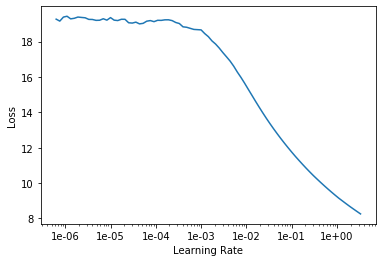

In [19]:
lenet_learner.summary()

## Finidng Ideal learning late
lenet_learner.lr_find()
lenet_learner.recorder.plot()

In [20]:
lenet_learner.crit = F.nll_loss

lenet_learner.fit_one_cycle(20,1e-2)


epoch,train_loss,valid_loss,accuracy,time
0,1.903499,1.770450,0.368400,01:33
1,1.565924,1.477662,0.468400,01:33
2,1.481454,1.400753,0.491100,01:33
3,1.425365,1.390816,0.512700,01:33
4,1.418014,1.326689,0.533700,01:33
5,1.413029,1.334927,0.529400,01:34
6,1.362374,1.315651,0.546700,01:33
7,1.313640,1.236026,0.571800,01:34
8,1.273413,1.224576,0.587400,01:33
9,1.265994,1.159277,0.595600,01:34


In [ ]:
lenet_learner.validate()

In [22]:
learnBase1 = Learner(data_labeled,model,loss_func=nn.CrossEntropyLoss(), metrics=accuracy)
learnBase1.fit_one_cycle(20, 1e-2)
learnBase1.crit = F.nll_loss


epoch,train_loss,valid_loss,accuracy,time
0,0.897627,0.944283,0.677000,00:05
1,0.929385,0.967989,0.665600,00:05
2,0.903743,1.045081,0.644200,00:05
3,0.894995,1.035057,0.652100,00:05
4,0.890820,1.132010,0.625900,00:06
5,0.886477,1.333396,0.585300,00:06
6,0.881424,1.293291,0.582600,00:06
7,0.874412,1.293057,0.595300,00:06
8,0.874823,1.302035,0.585500,00:06
9,0.877434,1.514294,0.532800,00:06


In [ ]:
learnerBase1.validate()

In [23]:
learnBase2 = Learner(data_labeled2,model,loss_func=nn.CrossEntropyLoss(), metrics=accuracy)
learnBase2.fit_one_cycle(20, 1e-2)
learnBase2.crit = F.nll_loss


epoch,train_loss,valid_loss,accuracy,time
0,0.977974,1.221339,0.611100,00:06
1,0.957458,1.182406,0.617500,00:06
2,0.943307,1.157039,0.624900,00:06
3,0.918137,1.172848,0.627700,00:06
4,0.899425,1.266826,0.623700,00:07
5,0.920600,1.376022,0.568400,00:06
6,0.935082,1.351903,0.565300,00:06
7,0.946556,1.631683,0.527700,00:06
8,0.958981,1.391403,0.567400,00:06
9,0.967554,1.419181,0.545700,00:07


In [86]:
learnBase2.validate()

[4.0584717, tensor(0.1546)]

In [87]:
learnBase3.validate()

[4.0584717, tensor(0.1546)]

In [88]:
learnBase4.validate()

[4.0584717, tensor(0.1546)]

In [24]:
learnBase3 = Learner(data_labeled3,model,loss_func=nn.CrossEntropyLoss(), metrics=accuracy)
learnBase3.fit_one_cycle(20, 1e-2)
learnBase3.crit = F.nll_loss


epoch,train_loss,valid_loss,accuracy,time
0,0.899637,1.257919,0.614200,00:07
1,0.892018,1.217356,0.605900,00:07
2,0.880259,1.229576,0.615900,00:07
3,0.897988,1.291156,0.605000,00:07
4,0.966334,1.330561,0.583300,00:07
5,1.009382,1.465350,0.524300,00:08
6,1.012942,1.402113,0.578600,00:08
7,0.988169,1.489970,0.555500,00:09
8,0.996498,1.328080,0.575800,00:08
9,0.954156,1.564844,0.559300,00:07


In [25]:
learnBase4 = Learner(data_labeled4,model,loss_func=nn.CrossEntropyLoss(), metrics=accuracy)
learnBase4.fit_one_cycle(20, 1e-2)
learnBase4.crit = F.nll_loss


epoch,train_loss,valid_loss,accuracy,time
0,0.961906,1.233781,0.618900,00:09
1,0.939106,1.203119,0.611000,00:09
2,0.954753,1.177217,0.615300,00:09
3,0.960140,1.385197,0.582600,00:09
4,1.084136,1.309003,0.558500,00:09
5,1.121801,1.490493,0.541100,00:09
6,1.118499,1.216530,0.598500,00:09
7,1.148841,1.581283,0.527400,00:09
8,1.112749,1.306919,0.586300,00:10
9,1.120361,1.293906,0.576400,00:09


In [27]:
learnBase5 = Learner(data_labeled5,model,loss_func=nn.CrossEntropyLoss(), metrics=accuracy)
learnBase5.fit_one_cycle(20, 1e-2)
learnBase5.crit = F.nll_loss


epoch,train_loss,valid_loss,accuracy,time
0,0.963734,1.194684,0.619400,00:12
1,0.953932,1.163833,0.627400,00:13
2,1.013981,1.353656,0.570700,00:13
3,1.098616,1.241733,0.584000,00:13
4,1.180589,1.423889,0.529100,00:13
5,1.204657,1.310414,0.567200,00:13
6,1.252582,1.391424,0.544300,00:13
7,1.218143,1.340117,0.580600,00:13
8,1.209949,1.345600,0.576100,00:13
9,1.176139,1.346092,0.564900,00:14


In [89]:
learnBase5.validate()

[4.0584717, tensor(0.1546)]